##### Problem Statement

Identify patterns/seasonality/trends in raw stock data inputs as well as accurately predict future stock prices in order to provide profitable investing advice to investors to obtain a strong ROI while minimizing their MAPE. Accurately determine the best performing stocks over specific time periods and locate best potential times to enter mid to long to positions (holding for weeks-to-years rather than day trading). (As MAPE decreases, ROI naturally increases)

##### Business Value

Identifying highest upside stocks with the lowest amount of risk to provide new investors with safe but rewarding returns on their investments.  Looking at ROI and MAPE of our models to identify which stocks are most accurately predicted, and thus more often realizing positive returns.  (Identifying trends in data such as best months to buy, worst months to buy, best potential time periods to hold...i.e when to get in/out).  Also reassuring investors that the technical analysis speaks for itself, and not to get caught up in the news cycles.

Going to use ARIMA models based on past information in a time series to predict future stock prices.

In [1]:
import datetime as dt
from functools import reduce
import math
from math import sqrt
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# Obtain

In [2]:
df_amazon = pd.read_csv(r"C:\Users\Nick\Desktop\Amazon.csv")
df_apple = pd.read_csv(r"C:\Users\Nick\Desktop\Apple.csv")
df_netflix = pd.read_csv(r"C:\Users\Nick\Desktop\Netflix.csv")
df_google = pd.read_csv(r"C:\Users\Nick\Desktop\Google.csv")
df_facebook = pd.read_csv(r"C:\Users\Nick\Desktop\Facebook.csv")

##### Assign company name to series values

In [3]:
amazon_list = ['AMZN' for i in range(5852)]
df_amazon['Company Name'] = amazon_list

In [4]:
apple_list = ['AAPL' for i in range(10016)]
df_apple['Company Name'] = apple_list

In [5]:
netflix_list = ['NFLX' for i in range(4581)]
df_netflix['Company Name'] = netflix_list

In [6]:
google_list = ['GOOGL' for i in range(4041)]
df_google['Company Name'] = google_list

In [7]:
facebook_list = ['FB' for i in range(2076)]
df_facebook['Company Name'] = facebook_list

# Explore

#### Convert 'Date' column to datetimes

In [8]:
df_amazon['Date'] = pd.to_datetime(df_amazon["Date"], errors = 'coerce')
df_amazon['month'] = df_amazon['Date'].dt.month
df_amazon['year'] = df_amazon['Date'].dt.year
df_amazon['week'] = df_amazon['Date'].dt.week


In [9]:
df_apple['Date'] = pd.to_datetime(df_apple["Date"], errors = 'coerce')
df_apple['month'] = df_apple['Date'].dt.month
df_apple['year'] = df_apple['Date'].dt.year
df_apple['week'] = df_apple['Date'].dt.week


In [10]:
df_google['Date'] = pd.to_datetime(df_google["Date"], errors = 'coerce')
df_google['month'] = df_google['Date'].dt.month
df_google['year'] = df_google['Date'].dt.year
df_google['week'] = df_google['Date'].dt.week


In [11]:
df_netflix['Date'] = pd.to_datetime(df_netflix["Date"], errors = 'coerce')
df_netflix['month'] = df_netflix['Date'].dt.month
df_netflix['year'] = df_netflix['Date'].dt.year
df_netflix['week'] = df_netflix['Date'].dt.week


In [12]:
df_facebook['Date'] = pd.to_datetime(df_facebook["Date"], errors = 'coerce')
df_facebook['month'] = df_facebook['Date'].dt.month
df_facebook['year'] = df_facebook['Date'].dt.year
df_facebook['week'] = df_facebook['Date'].dt.week


Look to see if anything stands out in dataframes from raw closing prices/volume.

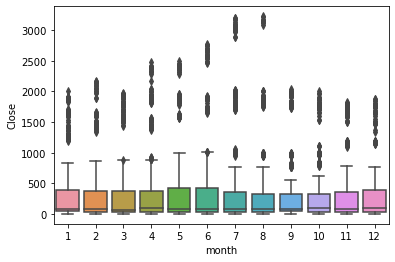

In [13]:
# amazon
sns.boxplot(x="month", y="Close", data=df_amazon)

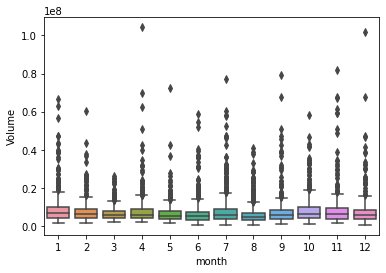

In [14]:
# amazon
sns.boxplot(x="month", y="Volume", data=df_amazon)

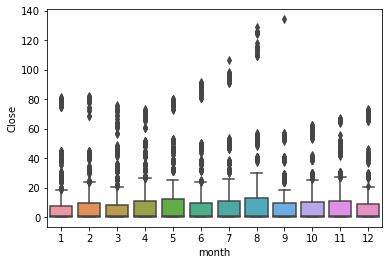

In [15]:
# apple
sns.boxplot(x="month", y="Close", data=df_apple)

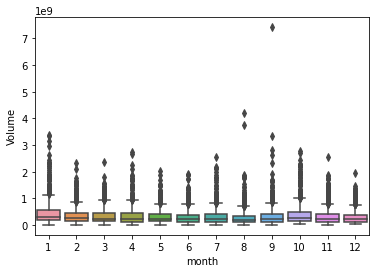

In [16]:
# apple
sns.boxplot(x="month", y="Volume", data=df_apple)

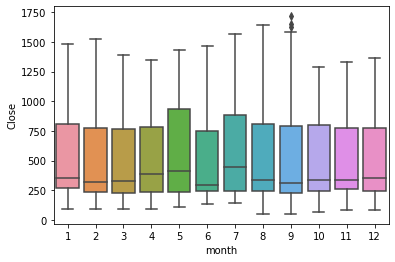

In [17]:
# google
sns.boxplot(x="month", y="Close", data=df_google)

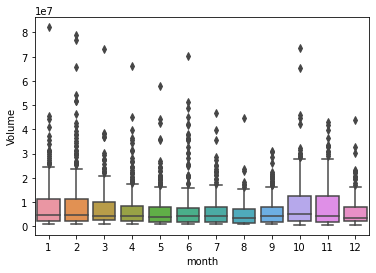

In [18]:
# google
sns.boxplot(x="month", y="Volume", data=df_google)

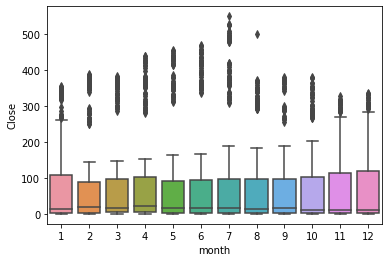

In [19]:
# netflix
sns.boxplot(x="month", y="Close", data=df_netflix)

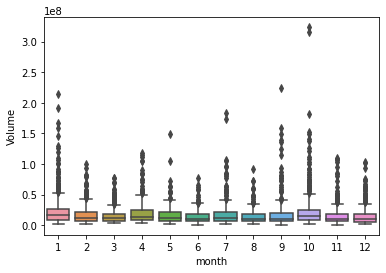

In [20]:
# netflix
sns.boxplot(x="month", y="Volume", data=df_netflix)

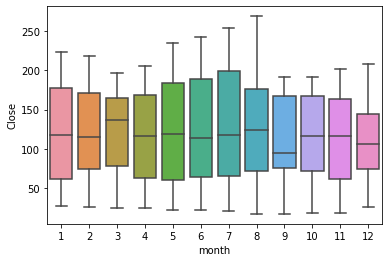

In [21]:
# facebook
sns.boxplot(x="month", y="Close", data=df_facebook)

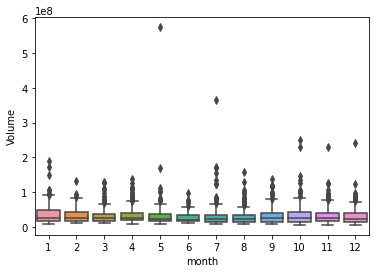

In [22]:
# facebook
sns.boxplot(x="month", y="Volume", data=df_facebook)

#### Create concatenated database

In [23]:
df_faang = pd.concat([df_amazon, df_apple, df_google, df_netflix, df_facebook])

df_faang.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Company Name,month,year,week
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0,AMZN,5,1997,20
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0,AMZN,5,1997,20
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,AMZN,5,1997,21
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200.0,AMZN,5,1997,21
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200.0,AMZN,5,1997,21


#### Use 'groupby' function to group data into weekly/monthly/yearly periods

In [24]:
# weekly
df_faang_weekly = df_faang.groupby(by=['Company Name', 'year', 'month', 'week'])['Close'].mean().reset_index()
df_faang_weekly = df_faang_weekly.rename(columns={'Close': 'Weekly Mean Close'})
df_faang_weekly_2012OW = df_faang_weekly[df_faang_weekly['year']>=2012]

# monthly
df_faang_monthly = df_faang.groupby(by=['Company Name', 'year', 'month'])['Close'].mean().reset_index()
df_faang_monthly = df_faang_monthly.rename(columns={'Close': 'Monthly Mean Close'})
df_faang_monthly_2012OW = df_faang_monthly[df_faang_monthly['year']>=2012]

# yearly
df_faang_yearly = df_faang.groupby(by=['Company Name', 'year'])['Close'].mean().reset_index()
df_faang_yearly = df_faang_yearly.rename(columns={'Close': 'Yearly Mean Close'})
df_faang_yearly_2012OW = df_faang_yearly[df_faang_yearly['year']>=2012]


In [25]:
# checking changes
df_faang_weekly.head()

,Company Name,year,month,week,Weekly Mean Close
0,AAPL,1980,12,1,0.156622
1,AAPL,1980,12,50,0.128348
2,AAPL,1980,12,51,0.118973
3,AAPL,1980,12,52,0.143415
4,AAPL,1981,1,1,0.154018


In [26]:
weekly_data_table = df_amazon.reset_index()

weekly_data_table = weekly_data_table[['Date', 'month', 'year', 'week']]
weekly_data_gb = weekly_data_table.groupby(by=['year', 'month', 'week'])['Date'].min()
weekly_data_gb.reset_index()

df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW.merge(weekly_data_gb, 
                                                            on=['year', 
                                                                'month', 
                                                                'week'], 
                                                            how='left')

df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW_dated.rename(columns={'Date': 'Start of Week'})

### amazon
amazon_df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated['Company Name']=='AMZN'].copy(deep=True)
amazon_df_faang_weekly_2012OW_dated = amazon_df_faang_weekly_2012OW_dated.set_index('Start of Week')

### apple
apple_df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated['Company Name']=='AAPL'].copy(deep=True)
apple_df_faang_weekly_2012OW_dated = apple_df_faang_weekly_2012OW_dated[apple_df_faang_weekly_2012OW_dated['Start of Week']==apple_df_faang_weekly_2012OW_dated['Start of Week']]
apple_df_faang_weekly_2012OW_dated = apple_df_faang_weekly_2012OW_dated.set_index('Start of Week')

### google
google_df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated['Company Name']=='GOOGL'].copy(deep=True)
google_df_faang_weekly_2012OW_dated = google_df_faang_weekly_2012OW_dated[google_df_faang_weekly_2012OW_dated['Start of Week']==google_df_faang_weekly_2012OW_dated['Start of Week']]
google_df_faang_weekly_2012OW_dated = google_df_faang_weekly_2012OW_dated.set_index('Start of Week')

### netflix
netflix_df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated['Company Name']=='NFLX'].copy(deep=True)
netflix_df_faang_weekly_2012OW_dated = netflix_df_faang_weekly_2012OW_dated.set_index('Start of Week')

### facebook
facebook_df_faang_weekly_2012OW_dated = df_faang_weekly_2012OW_dated[df_faang_weekly_2012OW_dated['Company Name']=='FB'].copy(deep=True)
facebook_df_faang_weekly_2012OW_dated = facebook_df_faang_weekly_2012OW_dated[facebook_df_faang_weekly_2012OW_dated['Start of Week']==facebook_df_faang_weekly_2012OW_dated['Start of Week']]
facebook_df_faang_weekly_2012OW_dated = facebook_df_faang_weekly_2012OW_dated.set_index('Start of Week')


In [27]:
# # Plotting the time series from 2012-present
# df_faang_weekly_2012OW_dated_dateindex = df_faang_weekly_2012OW_dated.set_index('Start of Week')
# df_faang_weekly_2012OW_dated_dateindex.plot(figsize=(18,8))
# plt.xlabel('Year', fontsize=20)
# plt.ylabel('Stock Price', fontsize=20)

In [28]:
# Looking at correlation strength between stocks
# merged_df.corr()

#### Setting period to 52 to see yearly data

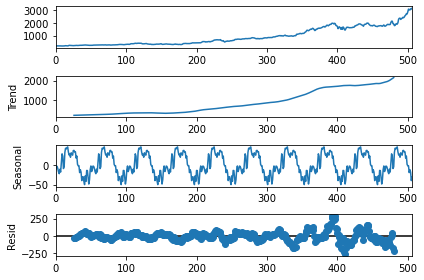

In [29]:
# Decompose amazon
ts = pd.Series(amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'].values)
decomposition_amazon = seasonal_decompose(ts, period=52)
decomposition_amazon.plot();

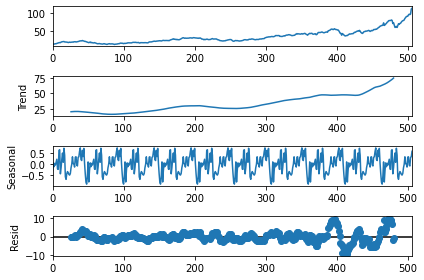

In [30]:
# Decompose apple
ts = pd.Series(apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'].values)
decomposition_apple = seasonal_decompose(ts, period=52)
decomposition_apple.plot();

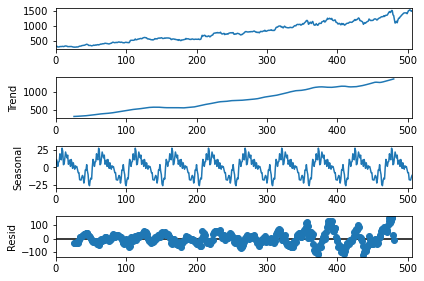

In [31]:
# Decompose google
ts = pd.Series(google_df_faang_weekly_2012OW_dated['Weekly Mean Close'].values)
decomposition_google = seasonal_decompose(ts, period=52)
decomposition_google.plot();

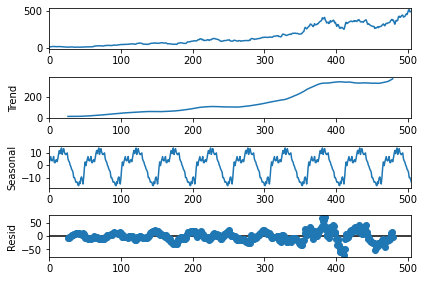

In [32]:
# Decompose netflix
ts = pd.Series(netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'].values)
decomposition_netflix = seasonal_decompose(ts, period=52)
decomposition_netflix.plot();

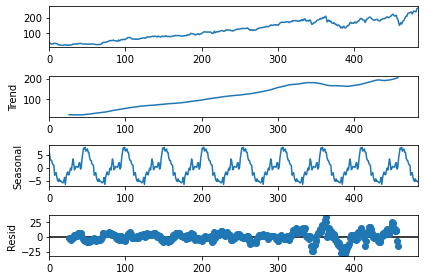

In [33]:
# Decompose facebook
ts = pd.Series(facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'].values)
decomposition_facebook = seasonal_decompose(ts, period=52)
decomposition_facebook.plot();

#### Testing for stationarity using ADF

In [34]:
### Creating function to plot rolling mean/std of df
def plot_rolling(df, date_col, close_col, ROLL=13):

    try:
        test = df[date_col]
    except:
        df = df.reset_index()
    
    # create rolling mean and std columns for data
    df['rolling_mean'] = df[close_col].rolling(window=ROLL).mean()
    df['rolling_std'] = df[close_col].rolling(window=ROLL).std()

    # plot data
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(df[date_col], 
        df[close_col], 
        color='red', 
        label=close_col)
    ax.plot(df[date_col], 
        df['rolling_mean'], 
        color='black', 
        label='Rolling Mean')
    ax.plot(df[date_col], 
        df['rolling_std'], 
        color='blue', 
        label='Rolling Std')
    ax.legend()
    fig.tight_layout()

##### Amazon rolling plot

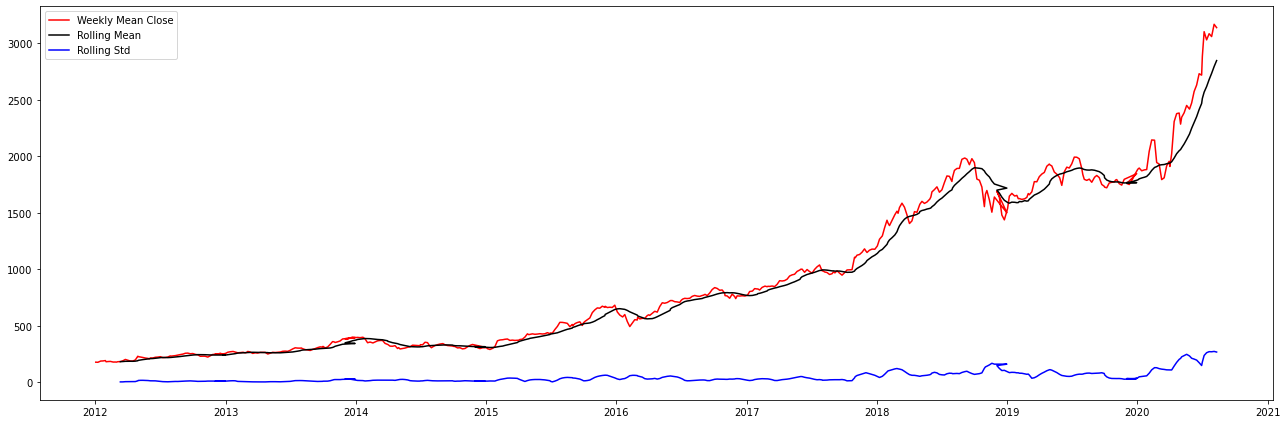

In [35]:
plot_rolling(amazon_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Weekly Mean Close')

##### Apple rolling plot

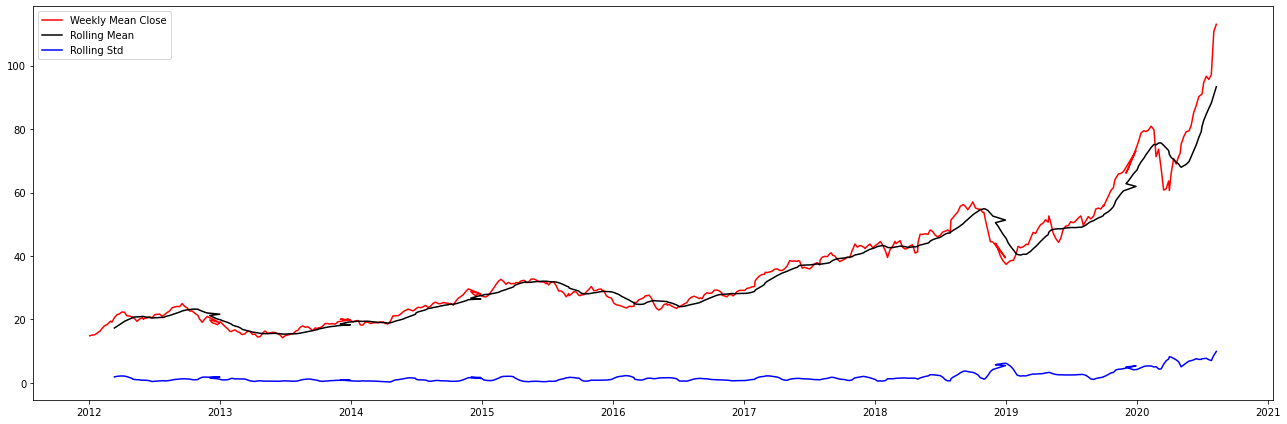

In [36]:
plot_rolling(apple_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Weekly Mean Close')

##### Google rolling plot

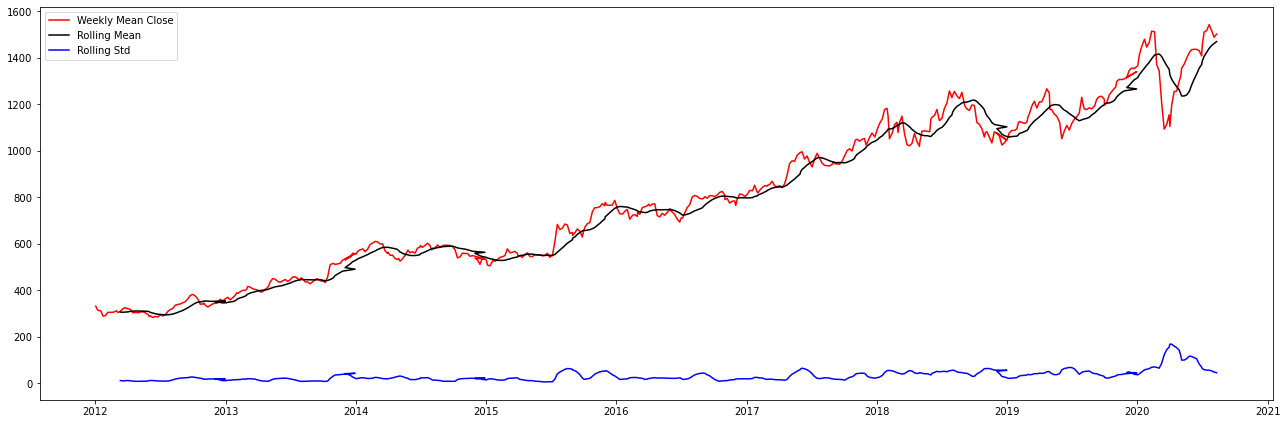

In [37]:
plot_rolling(google_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Weekly Mean Close')

##### Netflix rolling plot

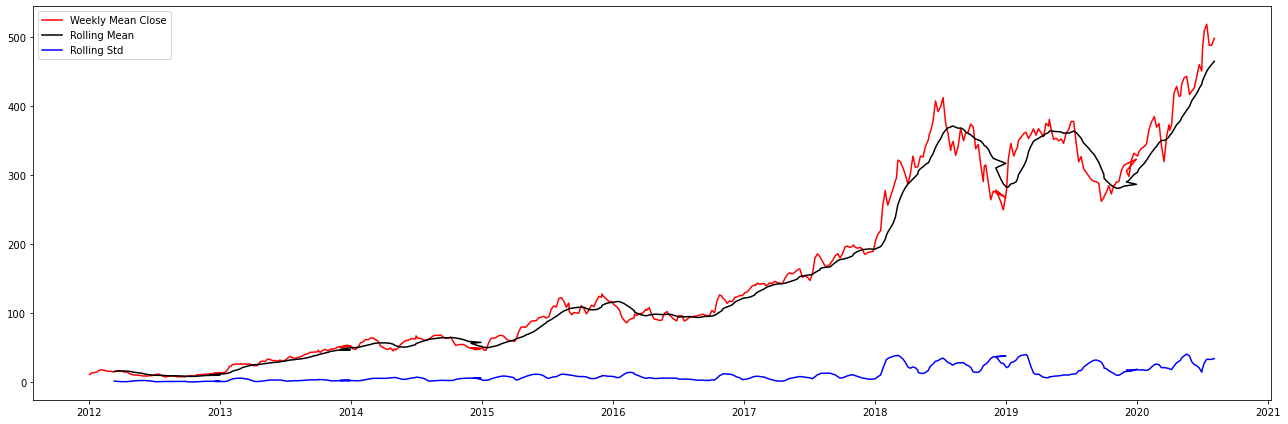

In [38]:
plot_rolling(netflix_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Weekly Mean Close')

##### Facebook rolling plot

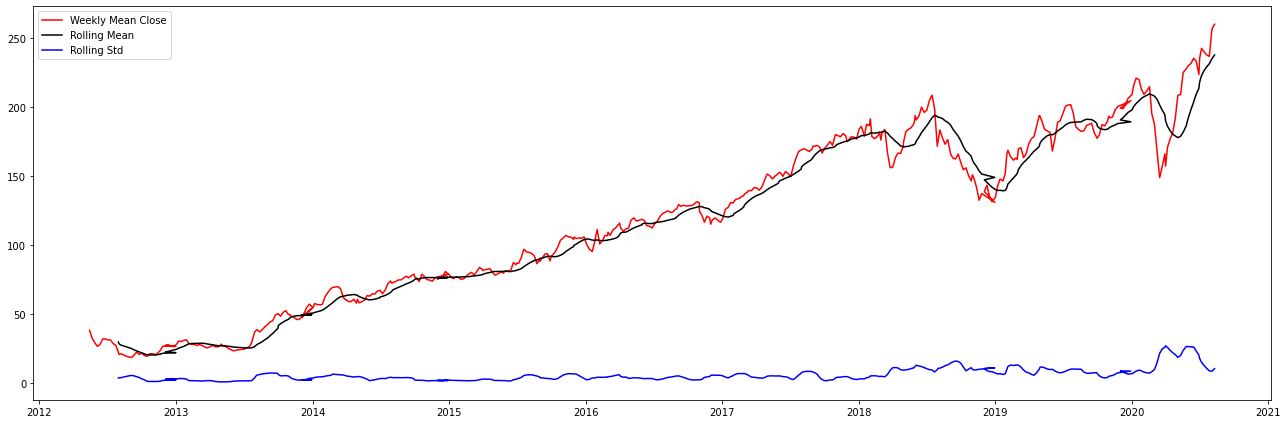

In [39]:
plot_rolling(facebook_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Weekly Mean Close')

#### Dickey-Fuller Testing

In [40]:
### The following block is modified from Claude Fried's Lesson on Time Series
### Create function to read out adfuller information clearly.

def adfuller_test(series):
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                            ADF: {adf}
                        P-value: {pvalue}
                       Used Lag: {usedlag}
         Number of Observations: {nobs}
      Critical Values (for ADP): {crit_vals}
                    ResultStore: {resstore}
         ''')

In [41]:
print('AMZN')
adfuller_test(amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('AAPL')
adfuller_test(apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('GOOGL')
adfuller_test(google_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('NFLX')
adfuller_test(netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

print('FB')
adfuller_test(facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'])

AMZN

                            ADF: 1.898502766675003
                        P-value: 0.9985256062984472
                       Used Lag: 15
         Number of Observations: 491
      Critical Values (for ADP): {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}
                    ResultStore: 4977.525190588249
         
AAPL

                            ADF: 2.8834783564753286
                        P-value: 1.0
                       Used Lag: 18
         Number of Observations: 488
      Critical Values (for ADP): {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
                    ResultStore: 1691.7736276044911
         
GOOGL

                            ADF: 0.4614964274354416
                        P-value: 0.9836546139957308
                       Used Lag: 19
         Number of Observations: 487
      Critical Values (for ADP): {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}

The p-value's for the time series above are all very close to 1.  We fail to reject the null hypothesis, and can determine that the time series aren't stationary.

#### De-trending the time series

In [42]:
amazon_df_faang_weekly_2012OW_dated['Close_Detrend'] = (amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
apple_df_faang_weekly_2012OW_dated['Close_Detrend'] = (apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
google_df_faang_weekly_2012OW_dated['Close_Detrend'] = (google_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - google_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
netflix_df_faang_weekly_2012OW_dated['Close_Detrend'] = (netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))
facebook_df_faang_weekly_2012OW_dated['Close_Detrend'] = (facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'] - facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'].shift(1))


                            ADF: -3.5655584319198557
                        P-value: 0.006454660696658872
                       Used Lag: 14
         Number of Observations: 491
      Critical Values (for ADP): {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}
                    ResultStore: 4979.354134385538
         


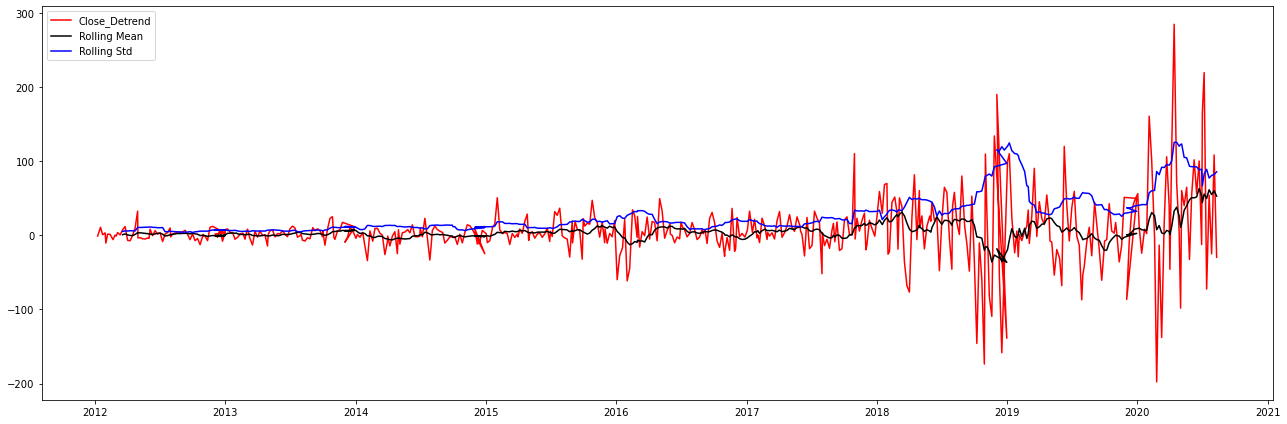

In [43]:
### amazon
adfuller_test(amazon_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(amazon_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -2.9941013370823306
                        P-value: 0.0354489451886579
                       Used Lag: 17
         Number of Observations: 488
      Critical Values (for ADP): {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
                    ResultStore: 1698.301926846657
         


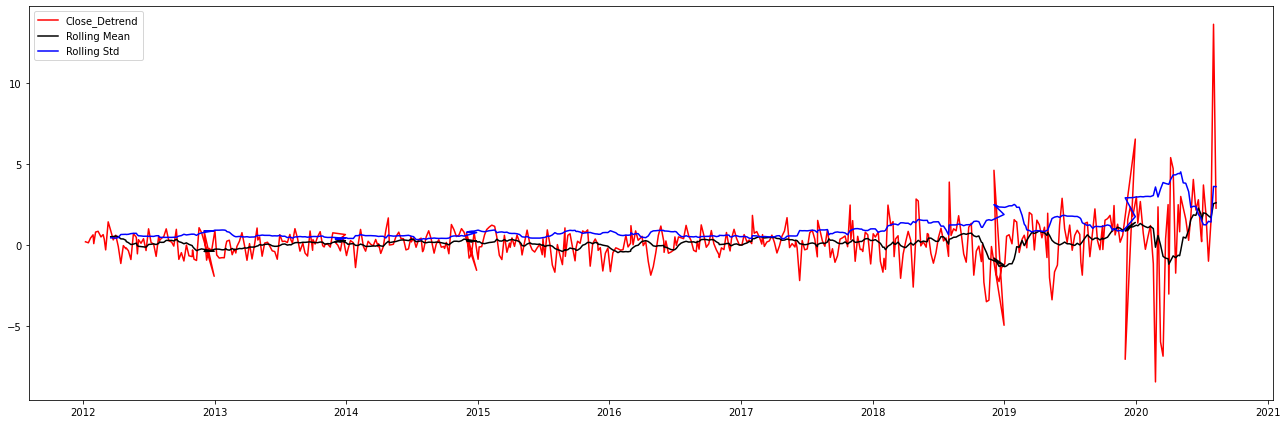

In [44]:
### apple
adfuller_test(apple_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(apple_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -7.158243880155085
                        P-value: 3.0150870029412803e-10
                       Used Lag: 18
         Number of Observations: 487
      Critical Values (for ADP): {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}
                    ResultStore: 4425.154837043934
         


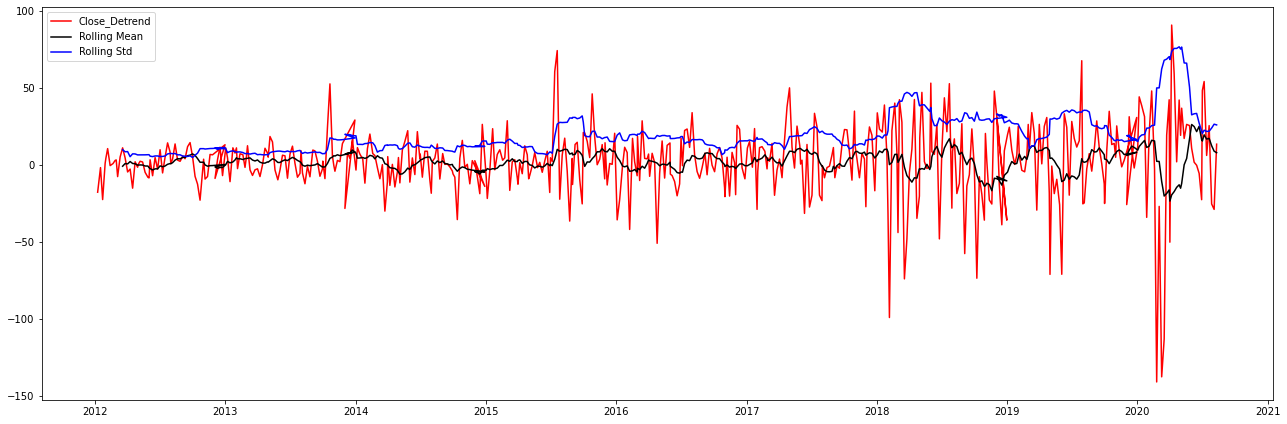

In [45]:
### google
adfuller_test(google_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(google_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -5.07350604567724
                        P-value: 1.5844581151875937e-05
                       Used Lag: 14
         Number of Observations: 490
      Critical Values (for ADP): {'1%': -3.4437660979098843, '5%': -2.8674565460819896, '10%': -2.569921291128696}
                    ResultStore: 3515.303351402727
         


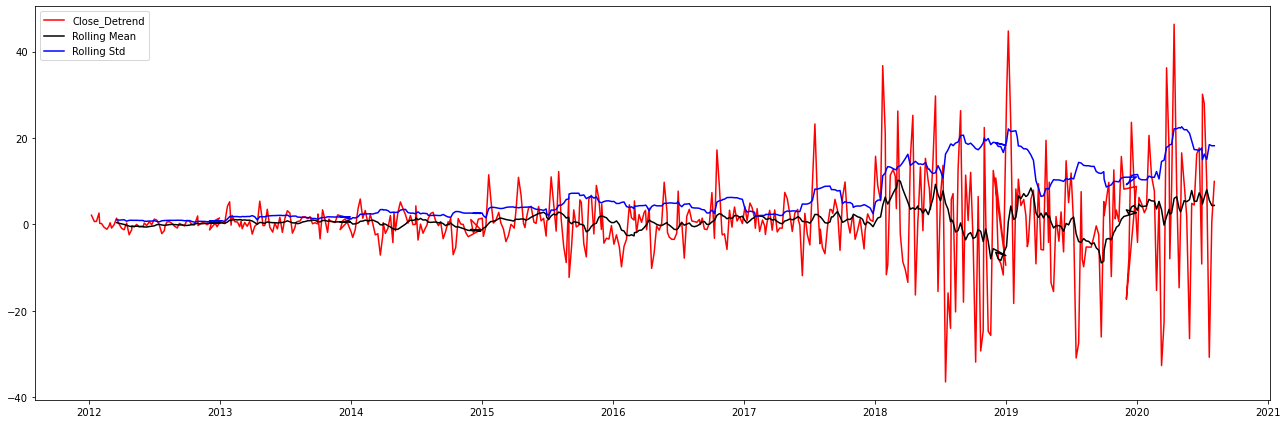

In [46]:
### netflix
adfuller_test(netflix_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(netflix_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')


                            ADF: -11.262477982322745
                        P-value: 1.6093016343221116e-20
                       Used Lag: 2
         Number of Observations: 481
      Critical Values (for ADP): {'1%': -3.4440184853599876, '5%': -2.867567599912013, '10%': -2.5699804779975883}
                    ResultStore: 2696.3295008691302
         


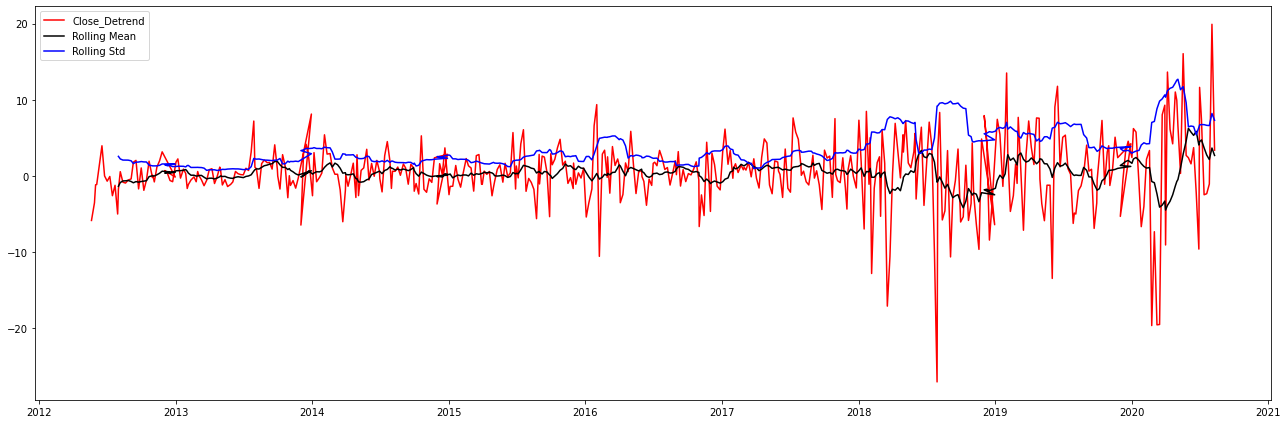

In [47]:
### facebook
adfuller_test(facebook_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna())

plot_rolling(facebook_df_faang_weekly_2012OW_dated, 'Start of Week', 
                                                 'Close_Detrend')

-All p-values given from the Dickey-Fuller test for the 'detrended' datasets are smaller than 0.05, so we can reject the null hypothesis, and determine the time series' are stationary.

# Model

##### Creating function to train/test/split data and run ARIMA model

In [48]:
def Arima_Time_Series(series, p, d, q, size_param=0.8):
    # The following block is modified from Jason Brown Lee's blog 'Machine Learning Mastery'
    # split into train and test sets
    X = series.values
    size = int(len(X) * size_param)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.plot(test)
    plt.title('Predicted vs Expected')
    plt.xlabel('Period')
    plt.ylabel('Price')
    plt.plot(predictions, color='red')
    plt.show()

#### Amazon model

##### Plotting ACF and PACF

In [49]:
amazon_series = amazon_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

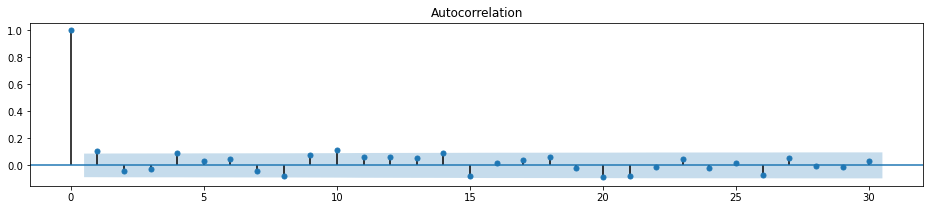

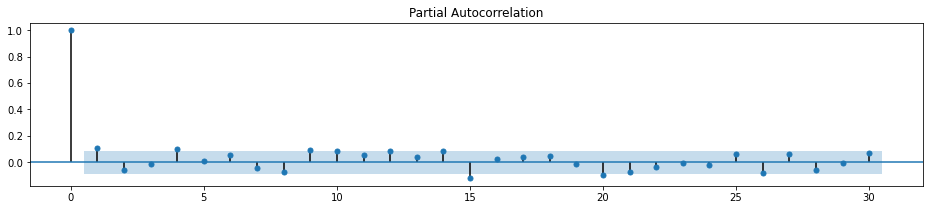

In [50]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(amazon_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(amazon_series, ax=ax, lags=30);

##### ARIMA Model

In [51]:
amazon_series = amazon_df_faang_weekly_2012OW_dated['Weekly Mean Close'].dropna()

predicted=1609.928433, expected=1506.635010
predicted=1493.242706, expected=1640.847998
predicted=1655.276887, expected=1501.969971
predicted=1503.876817, expected=1692.269989
predicted=1680.682632, expected=1639.620019
predicted=1649.115152, expected=1481.149975
predicted=1496.740163, expected=1438.630005
predicted=1443.996255, expected=1538.266683
predicted=1535.549590, expected=1648.458008
predicted=1648.504349, expected=1672.993994
predicted=1676.057186, expected=1649.422516
predicted=1653.711769, expected=1655.232514


C:\Users\Nick\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=1658.718514, expected=1626.229980
predicted=1630.603852, expected=1626.994019
predicted=1630.532270, expected=1619.921997
predicted=1623.649221, expected=1625.169983
predicted=1628.563475, expected=1637.579986
predicted=1640.798864, expected=1671.729980
predicted=1674.449270, expected=1660.860010
predicted=1664.762685, expected=1686.621997
predicted=1689.541977, expected=1777.060010
predicted=1778.777770, expected=1775.578003
predicted=1779.452594, expected=1821.001977
predicted=1823.815069, expected=1844.031982
predicted=1847.487790, expected=1858.604980
predicted=1862.283925, expected=1913.142017
predicted=1916.125650, expected=1932.475037
predicted=1936.257926, expected=1924.933309
predicted=1929.196083, expected=1915.834009
predicted=1920.090536, expected=1862.104004
predicted=1866.950523, expected=1842.986011
predicted=1847.117639, expected=1811.752472
predicted=1815.893570, expected=1743.828003
predicted=1747.770531, expected=1863.923999
predicted=1864.809661, expected=

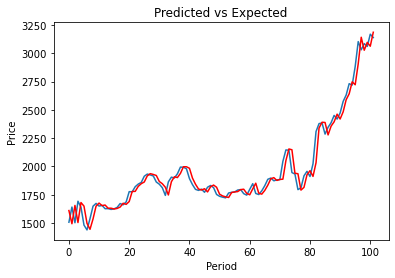

In [52]:
Arima_Time_Series(amazon_series, 1, 1, 0)

In [53]:
### Test RMSE = 75.143
### MAPE

#### Apple Model

##### Plotting ACF and PACF

In [54]:
apple_series = apple_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

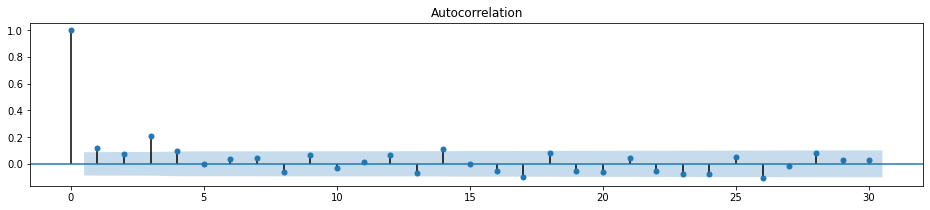

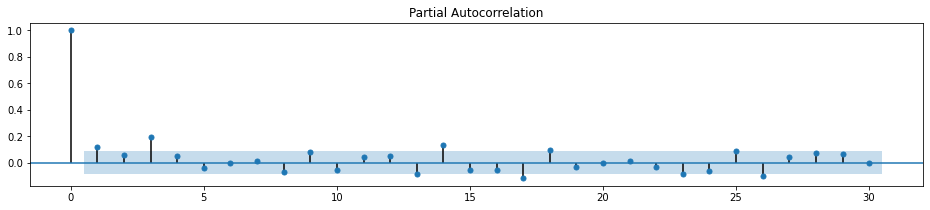

In [55]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(apple_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(apple_series, ax=ax, lags=30);

##### ARIMA Model

In [56]:
apple_series = apple_df_faang_weekly_2012OW_dated['Weekly Mean Close'].dropna()

predicted=47.304635, expected=44.494374
predicted=43.695417, expected=44.396500
predicted=44.386795, expected=39.435001
predicted=38.224743, expected=44.045001
predicted=44.355688, expected=42.188001
predicted=42.085776, expected=39.923000

C:\Users\Nick\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "



predicted=39.611740, expected=38.523749
predicted=38.169594, expected=37.364167
predicted=37.001046, expected=37.903999
predicted=37.763959, expected=38.534501
predicted=38.546492, expected=38.605000
predicted=38.636908, expected=40.166875
predicted=40.386657, expected=41.630001
predicted=41.954736, expected=43.051000
predicted=43.434827, expected=42.585999
predicted=42.759639, expected=42.936874
predicted=43.098046, expected=43.536249
predicted=43.721381, expected=43.742500
predicted=43.893227, expected=43.565501
predicted=43.650160, expected=45.568500
predicted=45.878235, expected=47.442500
predicted=47.881368, expected=47.133500
predicted=47.364784, expected=48.665001
predicted=49.014935, expected=49.902000
predicted=50.289957, expected=50.341875
predicted=50.650373, expected=51.437500
predicted=51.787224, expected=50.660000
predicted=50.790120, expected=52.618333
predicted=52.965529, expected=50.606999
predicted=50.605632, expected=47.219000
predicted=46.795998, expected=45.555000

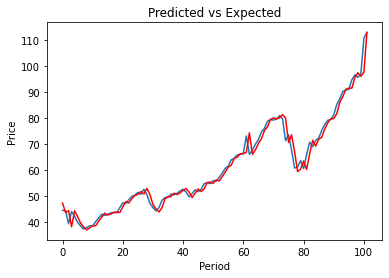

In [57]:
Arima_Time_Series(apple_series, 1, 1, 1)

In [58]:
### RMSE of 2.729
### MAPE

#### Google Model

In [59]:
google_series = google_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

##### Plotting ACF and PACF

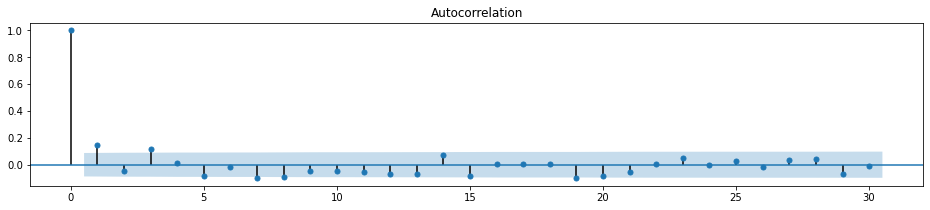

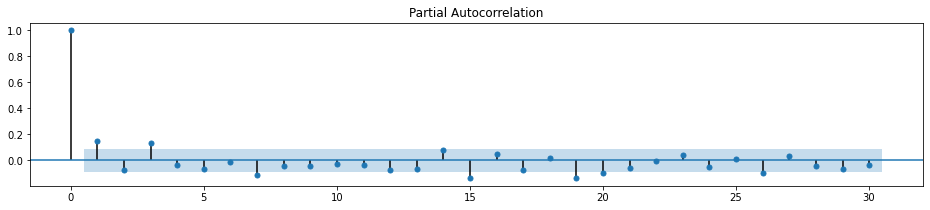

In [60]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(google_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(google_series, ax=ax, lags=30);

##### ARIMA Model

In [61]:
google_series = google_df_faang_weekly_2012OW_dated['Weekly Mean Close'].dropna()

predicted=1057.845097, expected=1032.850006
predicted=1032.031259, expected=1080.847998
predicted=1086.574575, expected=1044.959961
predicted=1044.068719, expected=1075.872467
predicted=1079.487623, expected=1062.762012
predicted=1063.683041, expected=1023.870007
predicted=1023.026647, expected=1033.025009
predicted=1035.174204, expected=1052.739990
predicted=1055.575077, expected=1077.247998
predicted=1080.486250, expected=1086.790015
predicted=1089.108319, expected=1087.137512
predicted=1088.862819, expected=1093.450012
predicted=1095.567231, expected=1118.619995
predicted=1122.012995, expected=1124.894019
predicted=1127.076098, expected=1121.431982
predicted=1122.968455, expected=1116.967499
predicted=1118.423247, expected=1122.195007
predicted=1124.289884, expected=1148.520020
predicted=1152.055300, expected=1157.673975
predicted=1160.105209, expected=1191.680029
predicted=1195.886179, expected=1212.244019
predicted=1215.641270, expected=1182.878003
predicted=1182.755660, expected=

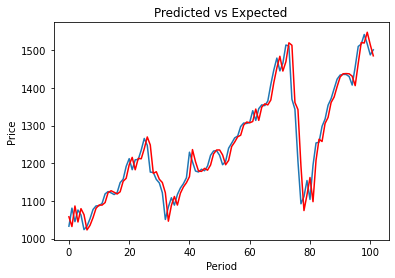

In [62]:
Arima_Time_Series(google_series, 1, 1, 0)

In [63]:
### RMSE = 35.496

#### Netflix Model

In [64]:
netflix_series = netflix_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

##### Plotting ACF and PACF

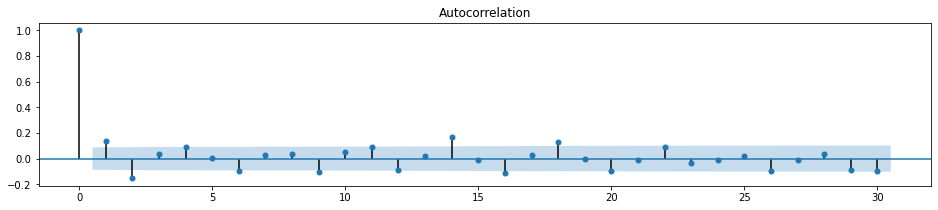

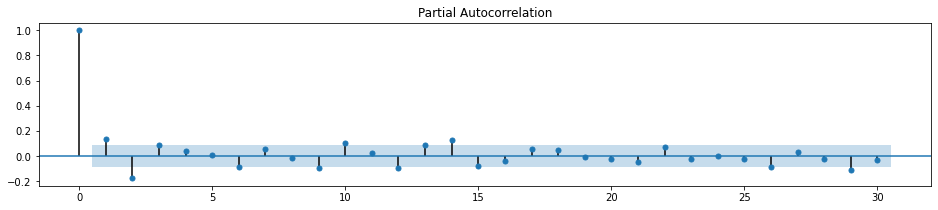

In [65]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(netflix_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(netflix_series, ax=ax, lags=30);

##### ARIMA Model

In [66]:
netflix_series = netflix_df_faang_weekly_2012OW_dated['Weekly Mean Close'].dropna()

predicted=315.897590, expected=290.294000
predicted=288.339459, expected=264.632507
predicted=261.715745, expected=277.117999
predicted=279.131340, expected=267.660004
predicted=267.198940, expected=278.412499
predicted=280.104055, expected=270.552002
predicted=270.353773, expected=261.495993
predicted=261.124228, expected=249.799999
predicted=249.068551, expected=278.810008
predicted=281.996157, expected=323.563995
predicted=330.638453, expected=346.252008
predicted=350.837320, expected=327.967499
predicted=325.838046, expected=336.180001
predicted=338.030326, expected=339.850006
predicted=341.054406, expected=350.323999
predicted=352.541210, expected=354.682001
predicted=356.019615, expected=360.455002
predicted=362.012866, expected=362.462502
predicted=363.469480, expected=357.320007
predicted=357.265256, expected=353.429999
predicted=353.545230, expected=359.323993
predicted=360.888769, expected=367.264001
predicted=369.152236, expected=358.147998
predicted=357.525196, expected=367

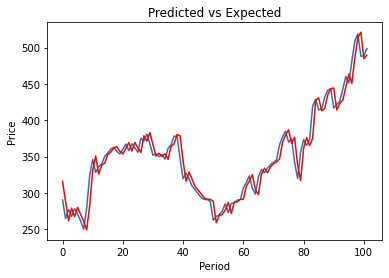

In [67]:
Arima_Time_Series(netflix_series, 1, 1, 0)

In [68]:
### RMSE = 15.019
### MAPE

#### Facebook Model

In [69]:
facebook_series = facebook_df_faang_weekly_2012OW_dated['Close_Detrend'].dropna()

##### Plotting ACF and PACF

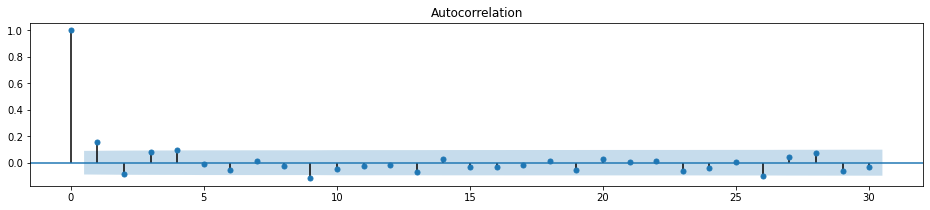

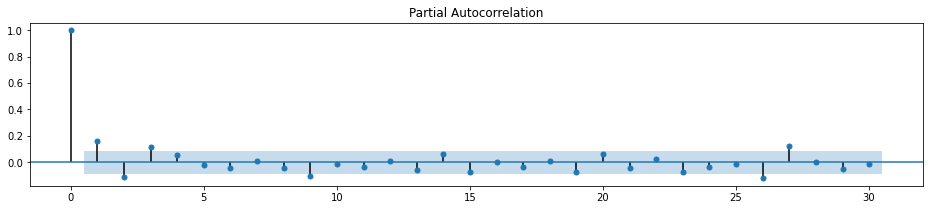

In [70]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(facebook_series, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(facebook_series, ax=ax, lags=30);

##### ARIMA Model

In [71]:
facebook_series = facebook_df_faang_weekly_2012OW_dated['Weekly Mean Close'].dropna()

predicted=142.815537, expected=135.088000
predicted=134.231793, expected=131.489998
predicted=133.003902, expected=135.123332
predicted=136.090230, expected=142.562000
predicted=142.718674, expected=148.043997
predicted=147.524306, expected=146.677502
predicted=145.962875, expected=152.192501
predicted=153.255362, expected=165.710007
predicted=166.320429, expected=168.922003
predicted=167.426529, expected=164.269998
predicted=163.949291, expected=161.694996
predicted=162.686055, expected=163.252499
predicted=164.103558, expected=162.279999
predicted=162.164616, expected=169.973999
predicted=171.279856, expected=170.701999
predicted=169.730124, expected=163.580002
predicted=163.256271, expected=166.415997
predicted=168.375276, expected=173.635998
predicted=173.946434, expected=177.388001
predicted=176.801511, expected=178.894997
predicted=178.875837, expected=186.510001
predicted=187.536241, expected=194.089996
predicted=193.989708, expected=193.676666
predicted=192.906880, expected=190

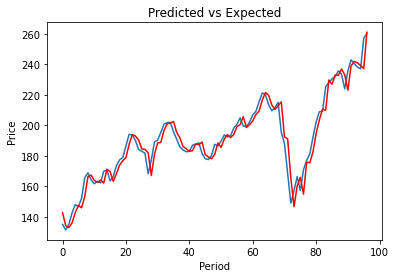

In [72]:
Arima_Time_Series(facebook_series, 3, 1, 0)

In [73]:
### RMSE = 6.754
### MAPE

In [74]:
### RMSE amazon= 75.143
### RMSE apple= 2.729
### RMSE google= 35.496
### RMSE netflix= 15.019
### RMSE facebook= 6.754

### MAPE VALUES TO COMPARE AND CONTRAST STOCKS

In [75]:
### Store predicted and expected values 
### to calculate MAPE for best model params for each stock

### Use MAPE to judge models performance against one another

### Be able to explain/understand ADF, ARIMA, Trends.

# Interpret

#### Conclusion

To summarize our findings, we have identified that there seem to be no clear 'indicators' in the data that stick out, other than the overall upward trend/growth of the stock market as a whole.

Most of these stocks seem to rise and fall together, and the prices changes are highly correlated with one another.  This would suggest these stocks as a whole trend down and up together.  (Note- not sure if this is due to the natural markets, news cycle, etc.)

I recommend to invest in any of the stocks that are currently on a downswing.  We should look at these stocks as if they are 'on sale' and we can get them for a cheaper price to maximize our return-on-invest for long term growth when we plan to hold.  These stocks have more potential for growth due to the overarching upward trend of the stocks selected mixed with the current low price and certainly prove to be a recipe for success.

#### Future Work

Look into stocks in multiple sectors other than tech.  It would be interesting to see if there are any obvious patterns from businesses that have super seasonal revenue streams and if that has an impact on stock price.  

Building a model that factors in product releases, news cycles, or company quarterly reports (although somewhat nuanced, could potentially be a clear indicator).  Use a mix of models somewhat like modern day stock traders that use complicated algorithms and graphical patterns to identify trends in data. 

Identifying optimal time intervals to hold stocks.  It is almost impossible to get in stocks at the absolute lows, and out at the absolute highs to maximize profits...since all indicators are 'lagging' indicators.  This is much more important when trading stocks daily rather than identifying simple long-term stocks to buy and hold. 

See if there is a strong link of price movement between certain stocks in the same industry and see if we can identify which 'controls' the market.  (i.e- Bitcoin moving before most other cryptos move with it...)

Research stock investing to see what percent of trading is done by bots, and what the bots are responding to. (i.e- news data, actual AR/MA trends...what are they optimized to do)

See if longer time series (i.e- more mature stocks) provide better predictive qualities or if new data is exponentially more important.